## Exercícios

Escolha um dos datasets apresentados (clima, passageiros, nascimentos-passaros, ou outro de interesse)

* modifique o shape de entrada para se adequar a rede neural
* monte uma rede neural RNN para predição
* modifique essa rede neural para utilizar uma camada LSTM
* mostre o RMSE da predição

In [79]:
from rubianets import *

from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import MinMaxScaler

Dataset shape: (144, 1)


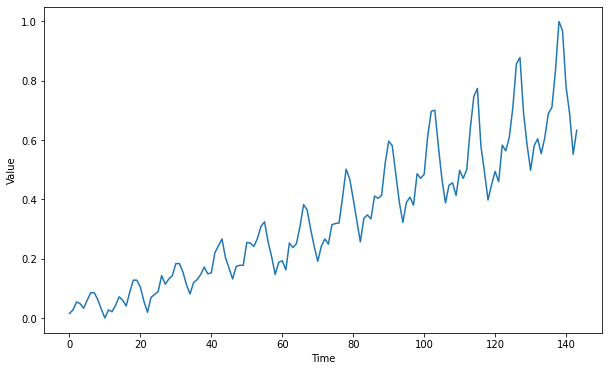

In [133]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    

data = pd.read_csv('dataset/AirPassengers.csv', usecols=[1]).values.astype('float32')
print('Dataset shape:', data.shape)

timer = np.arange(len(data))

scaler = MinMaxScaler(feature_range=(0, 1))
serie = scaler.fit_transform(data).flatten().tolist()

plt.figure(figsize=(10, 6))
plot_series(timer, serie)
plt.show()

In [134]:
split_time = 100
time_train = timer[:split_time]
x_train = serie[:split_time]
time_valid = timer[split_time:]
x_valid = serie[split_time:]

## Aplicando from_tensor_slices 
Embora não seja necessário neste problema devido ao pequeno dataset, vamos aplicar para treinar

In [135]:
def windowed_dataset(series, window_size, shift, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=shift, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    print('\nElementos disponíveis:', len(series))
    print('Graus de liberdade:', len(series) - shift - (window_size-1))
    print('Tamanho do batch:', batch_size)
    print('Número de batches:', (len(series) - shift - (window_size-1)) / batch_size)
    return dataset

## Montando a Rede Neural

In [193]:
window_size = 3 
shift = 1
batch_size = 4
val_batch_size = 4
shuffle_buffer_size = 10

tf.keras.backend.clear_session()

train_set = windowed_dataset(x_train, window_size, shift, batch_size=batch_size, 
                             shuffle_buffer=shuffle_buffer_size)
test_set = windowed_dataset(x_valid, window_size, shift, batch_size=val_batch_size, 
                             shuffle_buffer=shuffle_buffer_size)


Elementos disponíveis: 100
Graus de liberdade: 97
Tamanho do batch: 4
Número de batches: 24.25

Elementos disponíveis: 44
Graus de liberdade: 41
Tamanho do batch: 4
Número de batches: 10.25


### ajuste do shape de entrada usando expand_dims na primeira layer Lambda

In [194]:
def evaluate_history(history, test_set, x_valid, series, scaler):

    loss = model.evaluate(test_set, verbose=0)

    forecast = []
    for time in range(split_time-window_size, len(series) - window_size):
        forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
    y_hat = np.array(forecast)[:, 0, 0]
    
    x_valid = scaler.inverse_transform(np.array(x_valid).reshape(-1,1))
    y_hat = scaler.inverse_transform(np.array(y_hat).reshape(-1,1))

    plt.figure(figsize=(15,8))
    
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.title('Evolução do MSE')

    plt.subplot(2, 2, 3)
    plt.subplots_adjust(hspace=0.3)  
    plt.plot(time_valid, x_valid, label='Valor Verdadeiro')
    plt.plot(time_valid, y_hat, label='Valor Predito')
    plt.xlabel('Time')
    plt.title('Comparação do Resultado Predito (dataset de teste)')

    plt.subplot(2, 2, 2)
    plt.plot(x_valid, y_hat, 'o')
    plt.plot([x_valid.min(), x_valid.max()], [x_valid.min(), x_valid.max()], 'r-', lw=3)
    plt.title('Predito vs Observado')
    plt.xlabel('Valor Verdadeiro')
    plt.ylabel('Valor Predito')

    plt.subplot(2, 2, 4)
    plt.plot(time_valid, x_valid - y_hat, 'o')
    plt.plot([time_valid.min(), time_valid.max()], [0, 0], 'r-', lw=3)
    plt.title('Resíduo (verdadeiro - predito)')
    plt.xlabel('Time')
    plt.show()  

    rmse = np.sqrt(mean_squared_error(x_valid, y_hat))
    print('RMSE: %.3f' % rmse)

### MLP

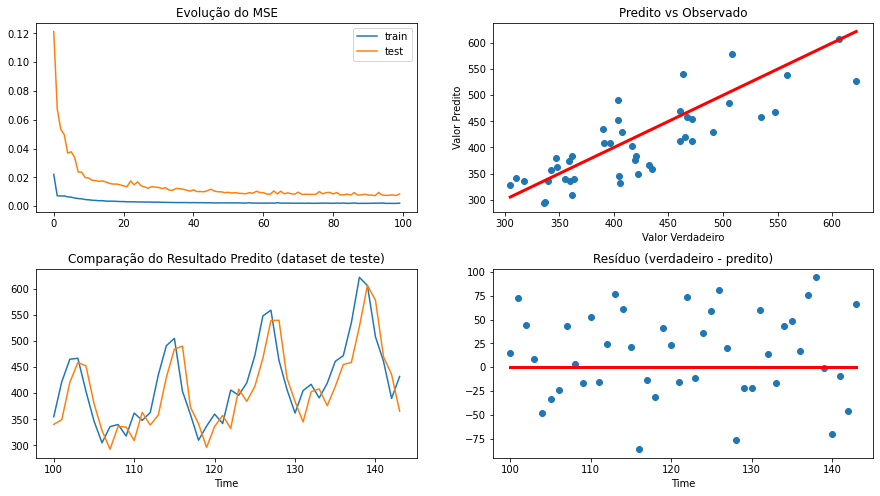

RMSE: 47.001


In [196]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(train_set, epochs=100, validation_data=test_set, verbose=0)

evaluate_history(history, test_set, np.array(x_valid), np.array(serie), scaler)

### SimpleRNN

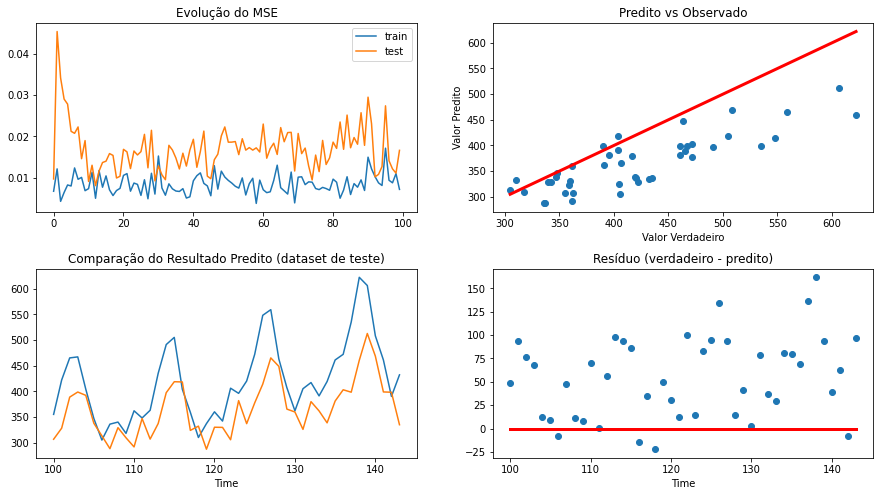

RMSE: 69.636


In [197]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.SimpleRNN(60, return_sequences=True, dropout=0.1),
  tf.keras.layers.SimpleRNN(60),
  tf.keras.layers.Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(train_set, epochs=100, validation_data=test_set, verbose=0)

evaluate_history(history, test_set, np.array(x_valid), np.array(serie), scaler)

### Mudança de SimpleRNN para LSTM

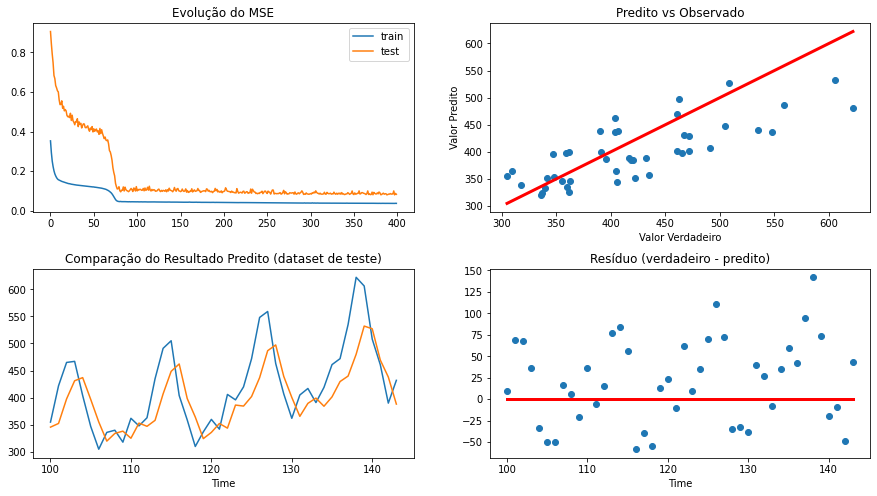

RMSE: 53.001


In [198]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  #tf.keras.layers.LSTM(60, return_sequences=True, dropout=0.0),
  tf.keras.layers.LSTM(2),
  tf.keras.layers.Dense(1)
])

model.compile(loss='mae', optimizer='adam')

history = model.fit(train_set, epochs=400, validation_data=test_set, verbose=0)

evaluate_history(history, test_set, np.array(x_valid), np.array(serie), scaler)